In [3]:
# Import libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
df = pd.read_csv('CBIS-DDSM_combined.csv')
df.head()

,pathology,left or right breast,image view,abnormality type,image_path
0,MALIGNANT,LEFT,CC,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.342386...
1,MALIGNANT,LEFT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.359308...
2,BENIGN,LEFT,CC,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.891800...
3,BENIGN,LEFT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295360...
4,BENIGN,RIGHT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.410524...


In [5]:
# Label Encoding for 'pathology' (MALIGNANT = 1, BENIGN = 0)
label_encoder = LabelEncoder()
df['pathology'] = label_encoder.fit_transform(df['pathology'])
df.head()

,pathology,left or right breast,image view,abnormality type,image_path
0,1,LEFT,CC,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.342386...
1,1,LEFT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.359308...
2,0,LEFT,CC,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.891800...
3,0,LEFT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295360...
4,0,RIGHT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.410524...


In [6]:
# Prepare image paths and labels
image_paths = df['image_path'].values
labels = df['pathology'].values

X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42, stratify=labels)

In [7]:
# ImageDataGenerator for rescaling and validation split
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

# Flowing images from dataframe for training
train_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': X_train, 'class': y_train}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),  # EfficientNetB0 requires 224x224 images
    batch_size=32,
    class_mode='raw',
    shuffle=True,
    subset='training'  # this is for training data
)

# Flowing images from dataframe for validation
validation_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': X_train, 'class': y_train}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False,
    subset='validation'  # this is for validation data
)

# Test data generator 
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': X_test, 'class': y_test}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

Found 1833 validated image filenames.


Found 458 validated image filenames.
Found 573 validated image filenames.


In [7]:
# Load the EfficientNetB0 model, with weights pre-trained on ImageNet, excluding the top fully connected layers
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers so they won't be updated during training
efficientnet_base.trainable = False

# Build the model
model = models.Sequential([
    efficientnet_base, 
    layers.Flatten(),  
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # prevents overfitting
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3), 
    layers.Dense(1, activation='sigmoid')  # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    32,113,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,294,308 (138.45 MB)

 Trainable params: 32,244,737 (123.00 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [8]:
# to get the best model in training
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'efficientnetb0_best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint_callback]  # Pass callback
)

c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5436 - loss: 5.6427
Epoch 1: val_loss improved from inf to 1.01938, saving model to efficientnetb0_best_model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 236s 4s/step - accuracy: 0.5439 - loss: 5.6240 - val_accuracy: 0.6485 - val_loss: 1.0194
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6202 - loss: 1.7921
Epoch 2: val_loss improved from 1.01938 to 0.71640, saving model to efficientnetb0_best_model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 246s 4s/step - accuracy: 0.6198 - loss: 1.7899 - val_accuracy: 0.6812 - val_loss: 0.7164
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6142 - loss: 0.9566
Epoch 3: val_loss improved from 0.71640 to 0.60026, saving model to efficientnetb0_best_model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 250s 4s/step - accuracy: 0.6144 - loss: 0.9555 - val_accuracy: 0.6987 - val_loss: 0.6003
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6606 - loss: 0.7169
Epoch 4: val_loss did no

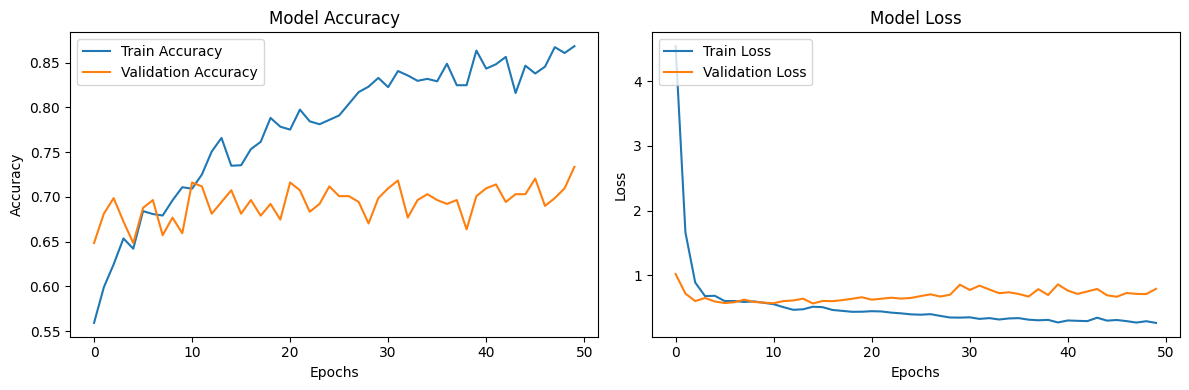

In [10]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [11]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_acc:.4f}")
# model.save('efficientnetb0_model.h5')

c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.7151 - loss: 0.8048
Test Accuracy: 0.7155


In [12]:
test_loss

0.7913254499435425

In [14]:
model.save('efficientnetb0_best_model.h5')

In [1]:
# Load the saved model
from tensorflow.keras.models import load_model
model = load_model('efficientnetb0_best_model.h5')

18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step


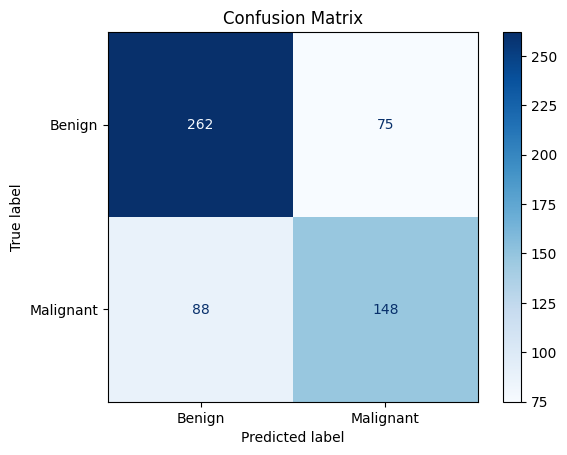

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get the true labels from the test generator
y_true = test_generator.labels
# Predict the labels
y_pred_prob = model.predict(test_generator, steps=len(test_generator))

# Convert predicted probabilities to binary labels (threshold at 0.5)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()
# cm
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [13]:
# testing on a sample image
from tensorflow.keras.preprocessing import image
import numpy as np

breast_cancer_model = tf.keras.models.load_model('efficientnetb0_best_model.keras')

# Function to preprocess the image
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) 
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return img_array

# Function to make a prediction
def predict_breast_cancer(img_path):
    preprocessed_img = preprocess_image(img_path)
    prediction = breast_cancer_model.predict(preprocessed_img)
    predicted_class = 'Malignant' if prediction[0][0] >= 0.5 else 'Benign'
    confidence_score = prediction[0][0] if predicted_class == 'Malignant' else (1 - prediction[0][0])
    return predicted_class, confidence_score

# Path to the image
img_path = 'CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.84350006812506903321489911520378117746/1-171.jpg'  # Benign example

# Call the prediction function
predicted_class, confidence_score = predict_breast_cancer(img_path)
print(f"The predicted class is: {predicted_class} with a confidence score of {confidence_score:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
The predicted class is: Benign with a confidence score of 0.9988


In [16]:
import tensorflow as tf
import numpy as np
import gradio as gr
from tensorflow.keras.preprocessing import image

# Load your pre-trained EfficientNet model
breast_cancer_model = tf.keras.models.load_model('efficientnetb0_best_model.keras')

# Function to preprocess the image
def preprocess_image(img, target_size=(224, 224)):
    img = img.resize(target_size)  # Resize the image to match the model's input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return img_array

# Function to make a prediction
def predict_breast_cancer(img):
    preprocessed_img = preprocess_image(img)
    prediction = breast_cancer_model.predict(preprocessed_img)
    predicted_class = 'Malignant' if prediction[0][0] >= 0.5 else 'Benign'
    confidence_score = prediction[0][0] if predicted_class == 'Malignant' else (1 - prediction[0][0])
    return predicted_class, confidence_score

# Create Gradio interface using the updated API
interface = gr.Interface(
    fn=predict_breast_cancer,          # Function to call for prediction
    inputs=gr.Image(type="pil"),  # Input image
    outputs=[
        gr.Textbox(label="Prediction"),       # Predicted class
        gr.Textbox(label="Confidence Score")  # Confidence score
    ],
    title="Breast Cancer Detection",
    description="Upload a mammogram image, and the model will classify it as either 'Malignant' or 'Benign' with a confidence score."
)

# Launch the Gradio app
interface.launch()


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
